<a href="https://colab.research.google.com/github/AarifCha/Hamiltonian-Graph-Networks/blob/main/HamiltonianNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import tensorflow as tf
from typing import Type
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# MLP Builder

In [ ]:
def build_mlp(num_hidden_layers: int,
              hidden_size: int,
              output_size: int,
              activation: str = "tanh",
              activate_final: bool = False,
              name: str = "mlp"):
    output_sizes = [hidden_size] * num_hidden_layers + [output_size]
    mlp = tf.keras.Sequential(name = name)
    rate = 0.2
    for layer_i, size in enumerate(output_sizes):
        layer_activation = activation
        layer_bias = True
        if not activate_final and layer_i == len(output_sizes) - 1:
            layer_activation = None
            layer_bias = False
    #        rate = 0.0
        mlp.add(tf.keras.layers.Dense(
                size,
                activation = layer_activation,
                use_bias = layer_bias,
                kernel_initializer = "variance_scaling",
                bias_initializer = "zeros",
  #              kernel_regularizer = tf.keras.regularizers.L2(0.01),
  #              bias_regularizer = tf.keras.regularizers.L2(0.01),
                name = f"{name}/dense_{layer_i}"))
     #   mlp.add(tf.keras.layers.Dropout(rate))
    return mlp

# Model

In [ ]:
class Hamiltonian(tf.keras.layers.Layer):
    def __init__(self, *,
                  HamiltonianMLP: Type[tf.keras.layers.Layer],
                  **kwargs):
      super().__init__(name = "HamiltonianLayer", **kwargs)
      self._HamiltonianMLP = HamiltonianMLP
    #  self._pdf_avg = 1

    def call(self, q: tf.Tensor, p: tf.Tensor):
      with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
        tape0.watch(q)
        tape1.watch(p)
        Hamiltonian = self._HamiltonianMLP(tf.reshape(tf.concat([[q],[p]],axis=-1),(-1,2)))
        qdot = tf.reshape(tape1.gradient(Hamiltonian, p), (-1,))
        pdot = -1*tf.reshape(tape0.gradient(Hamiltonian, q), (-1,))
      return qdot, pdot, tf.reshape(Hamiltonian, (-1,))

In [ ]:
tf.keras.backend.clear_session()

HamiltonianMLP = build_mlp(num_hidden_layers = 5,
                        hidden_size = 16,
                        output_size = 1,
                        activation = "tanh",
                        activate_final = False,
                        name = "HamiltonianMLP")

HamiltonianLayer = Hamiltonian(HamiltonianMLP = HamiltonianMLP)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.50),
    )

q = tf.keras.Input(shape = (1,))
p = tf.keras.Input(shape = (1,))

output = HamiltonianLayer(q = q, p = p)

model = tf.keras.Model(inputs = (q,p), outputs = output, name="HamiltonianIntegrator")
model.summary()

Model: "HamiltonianIntegrator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 HamiltonianLayer (Hamilton  ((None,),                    1152      ['input_1[0][0]',             
 ian)                         (None,),                               'input_2[0][0]']             
                              (None,))                                                            
                                                                              

# Data Generation

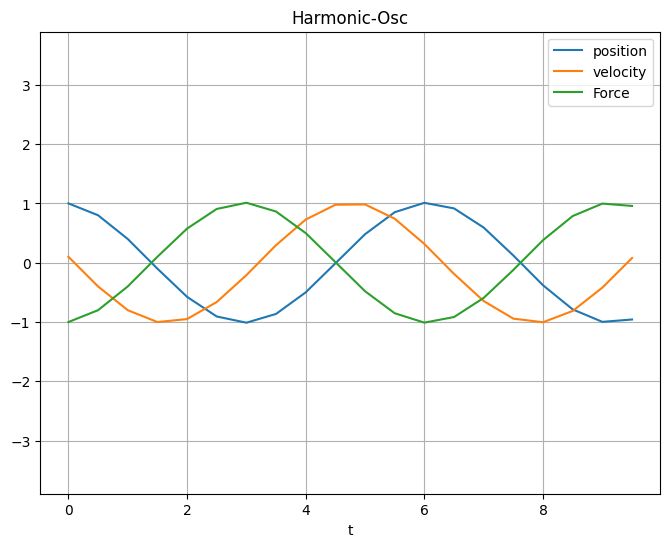

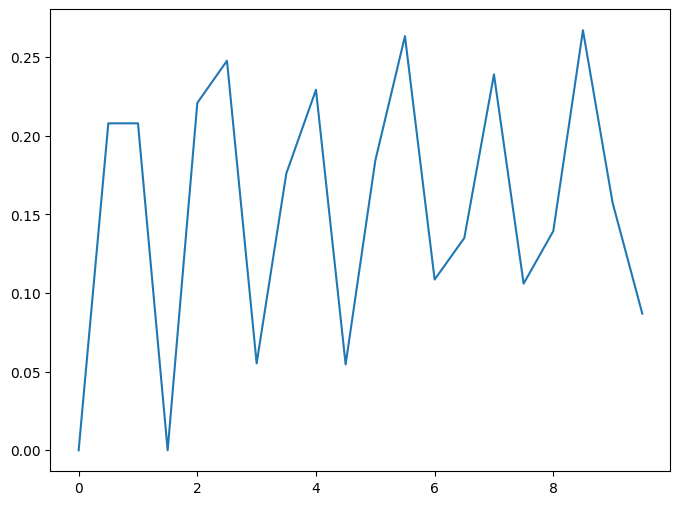

In [ ]:
#Taking m = k

def get_acc(x):
  return -x

def leapfrogIntStep(x,vx,dt):
  ax = get_acc(x)
  vxo = vx + dt*ax
  xo = x + dt*vxo
  # ax = get_acc(x)
  # vxo = vx + 0.5 * ax * dt
  # xo = x + vxo * dt
  # axo = get_acc(xo)
  # vxo += 0.5 * axo * dt
  return xo, vxo, ax #(ax+axo)/2

def leapfrogInt(x_values, vx_values, Fx_values, dt):
    for i in range(1, len(x_values)):
        x_values[i], vx_values[i], Fx_values[i-1] = leapfrogIntStep(
            x_values[i-1], vx_values[i-1], dt)

def gen_trajectory(x0,vx0,ax0,t_values,dt):
    x_values = np.zeros_like(t_values)
    vx_values = np.zeros_like(t_values)
    Fx_values = np.zeros_like(t_values)

    x_values[0] = x0
    vx_values[0] = vx0
    Fx_values[0] = ax0

    leapfrogInt(x_values, vx_values, Fx_values, dt)
    return (x_values, vx_values, Fx_values)

dt = 0.5  # Time step
tend = 100 # Final Time
t_values = np.arange(0, tend, dt)
x1, vx1, Fx1 = gen_trajectory(1,0.1,0,t_values,dt)

plt.figure(figsize=(8, 6))
plt.plot(t_values[:20], x1[:20], label='position')
plt.plot(t_values[:20], vx1[:20], label='velocity')
plt.plot(t_values[:20], Fx1[:20], label='Force')
plt.xlabel('t')
plt.title('Harmonic-Osc')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()


def Energy(x,vx):
  return 1/2*vx**2 + 1/2*x**2

plt.figure(figsize=(8,6))
plt.plot(t_values[:20], (np.abs(Energy(x1,vx1)-Energy(1,0.1))/Energy(1,0.1))[:20])

data = tf.data.Dataset.from_tensor_slices(((x1[:-1],vx1[:-1]), (vx1[:-1],Fx1[:-1],Energy(x1,vx1)[:-1]))).shuffle(buffer_size=1000).batch(32)
# for x,y in data.take(2):
#   print(x)
#   print(y[0])

# Loss and Training

In [ ]:
def custom_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)

  qdot_true = y_true[0]
  pdot_true = y_true[1]
  H_true = y_true[2]

  qdot_pred = y_pred[0]
  pdot_pred = y_pred[1]
  H_pred = y_pred[2]

  qdot_loss = tf.math.reduce_sum(tf.math.square(qdot_true - qdot_pred))*1/2
  pdot_loss = tf.math.reduce_sum(tf.math.square(pdot_true - pdot_pred))*1/2
  H_loss = tf.math.reduce_sum(tf.math.square(H_true - H_pred))*1/2

  loss = pdot_loss + H_loss + qdot_loss

  #loss = tf.reduce_sum(tf.math.square(tf.subtract(tf.reshape(tf.nest.flatten(y_pred),tf.shape(y_true)) , tf.nest.flatten(y_true))))
  return loss

#custom_loss(([1,1],[1,2]),([1,2],[1,2]))

In [ ]:
epochs = 50
steps_per_epoch = data.cardinality().numpy()
loss_hist = np.zeros(epochs)

for epoch in range(epochs):
    print("\nEpoch %d" % (epoch+1,))
    total_loss = 0
    pdf_avg = 0
    with tqdm(total=steps_per_epoch) as pbar:
      for step, (x_train, y_train) in enumerate(data):
        with tf.GradientTape() as tape:
          pred = model(x_train, training=True)
          loss_value = custom_loss(y_train, pred)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        total_loss += tf.reduce_mean(loss_value)
        pbar.update(1)
        pbar.set_description(f'Loss: {total_loss / (step + 1):.4f}')
    loss_hist[epoch] = total_loss/(step+1)


Epoch 1


Loss: 18.6520: 100%|██████████| 7/7 [00:00<00:00, 11.00it/s]



Epoch 2


Loss: 17.8037: 100%|██████████| 7/7 [00:00<00:00, 14.66it/s]



Epoch 3


Loss: 17.3099: 100%|██████████| 7/7 [00:00<00:00, 14.51it/s]



Epoch 4


Loss: 16.7210: 100%|██████████| 7/7 [00:00<00:00, 14.42it/s]



Epoch 5


Loss: 16.0654: 100%|██████████| 7/7 [00:00<00:00, 13.81it/s]



Epoch 6


Loss: 15.2996: 100%|██████████| 7/7 [00:00<00:00, 13.64it/s]



Epoch 7


Loss: 14.3248: 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]



Epoch 8


Loss: 13.1214: 100%|██████████| 7/7 [00:00<00:00, 15.19it/s]



Epoch 9


Loss: 11.6244: 100%|██████████| 7/7 [00:00<00:00, 11.24it/s]



Epoch 10


Loss: 9.8122: 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]



Epoch 11


Loss: 7.7092: 100%|██████████| 7/7 [00:00<00:00, 15.69it/s]



Epoch 12


Loss: 5.4965: 100%|██████████| 7/7 [00:00<00:00, 11.22it/s]



Epoch 13


Loss: 3.4365: 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]



Epoch 14


Loss: 1.9197: 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]



Epoch 15


Loss: 1.1593: 100%|██████████| 7/7 [00:00<00:00, 11.21it/s]



Epoch 16


Loss: 0.8648: 100%|██████████| 7/7 [00:00<00:00, 13.56it/s]



Epoch 17


Loss: 0.7122: 100%|██████████| 7/7 [00:00<00:00, 12.95it/s]



Epoch 18


Loss: 0.5402: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]



Epoch 19


Loss: 0.4018: 100%|██████████| 7/7 [00:01<00:00,  5.54it/s]



Epoch 20


Loss: 0.3111: 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]



Epoch 21


Loss: 0.2482: 100%|██████████| 7/7 [00:00<00:00, 11.19it/s]



Epoch 22


Loss: 0.2038: 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]



Epoch 23


Loss: 0.1577: 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]



Epoch 24


Loss: 0.1274: 100%|██████████| 7/7 [00:00<00:00, 11.21it/s]



Epoch 25


Loss: 0.1124: 100%|██████████| 7/7 [00:00<00:00, 14.62it/s]



Epoch 26


Loss: 0.0899: 100%|██████████| 7/7 [00:00<00:00, 14.29it/s]



Epoch 27


Loss: 0.0798: 100%|██████████| 7/7 [00:00<00:00, 13.74it/s]



Epoch 28


Loss: 0.0670: 100%|██████████| 7/7 [00:00<00:00, 11.22it/s]



Epoch 29


Loss: 0.0602: 100%|██████████| 7/7 [00:00<00:00, 13.27it/s]



Epoch 30


Loss: 0.0539: 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]



Epoch 31


Loss: 0.0496: 100%|██████████| 7/7 [00:00<00:00, 11.24it/s]



Epoch 32


Loss: 0.0454: 100%|██████████| 7/7 [00:00<00:00, 11.17it/s]



Epoch 33


Loss: 0.0421: 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]



Epoch 34


Loss: 0.0392: 100%|██████████| 7/7 [00:00<00:00, 14.03it/s]



Epoch 35


Loss: 0.0349: 100%|██████████| 7/7 [00:00<00:00, 11.20it/s]



Epoch 36


Loss: 0.0330: 100%|██████████| 7/7 [00:00<00:00, 11.33it/s]



Epoch 37


Loss: 0.0305: 100%|██████████| 7/7 [00:00<00:00, 11.06it/s]



Epoch 38


Loss: 0.0291: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]



Epoch 39


Loss: 0.0276: 100%|██████████| 7/7 [00:00<00:00, 11.25it/s]



Epoch 40


Loss: 0.0256: 100%|██████████| 7/7 [00:00<00:00, 14.85it/s]



Epoch 41


Loss: 0.0237: 100%|██████████| 7/7 [00:00<00:00, 11.25it/s]



Epoch 42


Loss: 0.0227: 100%|██████████| 7/7 [00:00<00:00, 11.21it/s]



Epoch 43


Loss: 0.0215: 100%|██████████| 7/7 [00:00<00:00, 11.22it/s]



Epoch 44


Loss: 0.0198: 100%|██████████| 7/7 [00:00<00:00, 13.80it/s]



Epoch 45


Loss: 0.0185: 100%|██████████| 7/7 [00:00<00:00, 14.83it/s]



Epoch 46


Loss: 0.0178: 100%|██████████| 7/7 [00:00<00:00, 11.21it/s]



Epoch 47


Loss: 0.0168: 100%|██████████| 7/7 [00:00<00:00, 14.54it/s]



Epoch 48


Loss: 0.0157: 100%|██████████| 7/7 [00:00<00:00, 11.18it/s]



Epoch 49


Loss: 0.0149: 100%|██████████| 7/7 [00:00<00:00, 15.31it/s]



Epoch 50


Loss: 0.0142: 100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


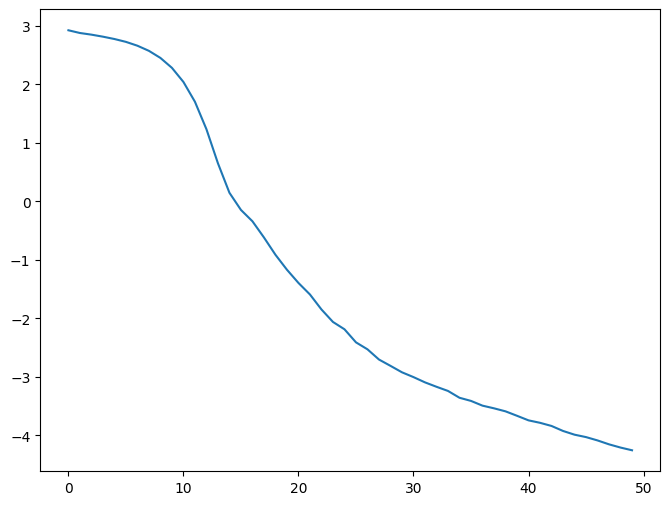

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(epochs),np.log(loss_hist))

# Testing Model

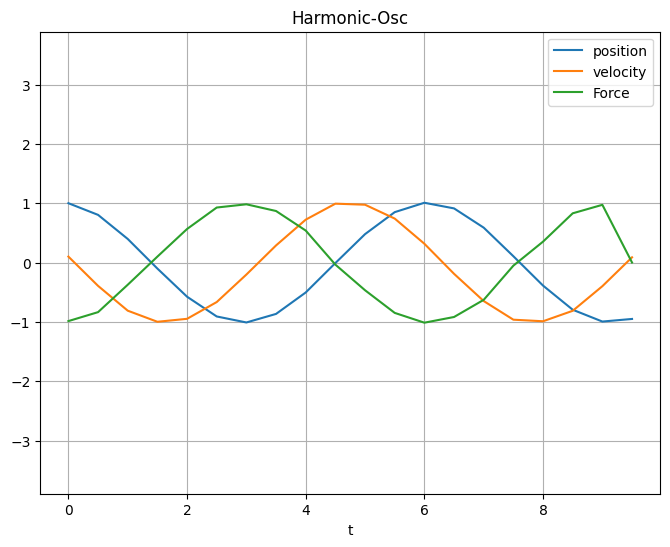

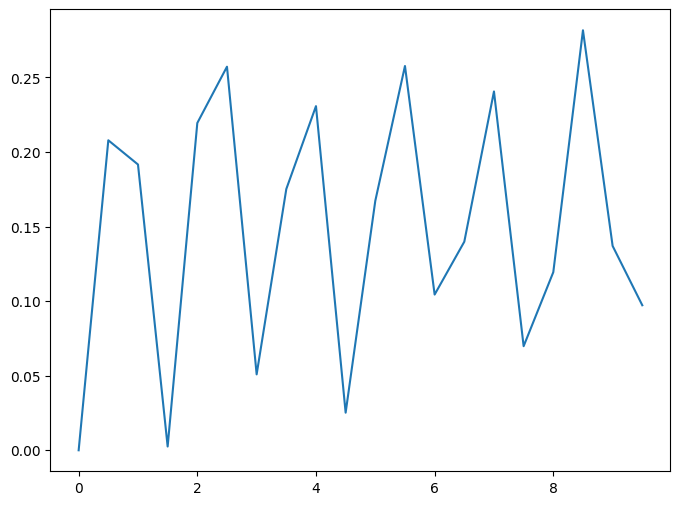

In [ ]:
def get_acc_vel(x,vx):
  v, a, H = model((x,vx))
  return v,a

def leapfrogIntStep(x,vx,dt):
  vxp, ax = get_acc_vel(x,vx)
  vxo = vx + dt*ax
  xo = x + dt*vxo
  # vxp, ax = get_acc_vel(x,vx)
  # vxo = vx + 0.5 * ax * dt
  # xo = x + vxo * dt
  # vxp, axo = get_acc_vel(xo,vxo)
  # vxo = vxo + 0.5 * axo * dt

  return xo, vxo, ax #(ax+axo)/2

def leapfrogInt(x_values, vx_values, Fx_values, dt):
    for i in range(1, len(x_values)):
        x_values[i], vx_values[i], Fx_values[i-1] = leapfrogIntStep(
            x_values[i-1], vx_values[i-1], dt)

def gen_trajectory(x0,vx0,ax0,t_values,dt):
    x_values = np.zeros_like(t_values)
    vx_values = np.zeros_like(t_values)
    Fx_values = np.zeros_like(t_values)

    x_values[0] = x0
    vx_values[0] = vx0
    Fx_values[0] = ax0

    leapfrogInt(x_values, vx_values, Fx_values, dt)
    return (x_values, vx_values, Fx_values)

dt = 0.5  # Time step
tend = 10 # Final Time
t_values = np.arange(0, tend, dt)
x0 = 1
v0 = 0.1
x1, vx1, Fx1 = gen_trajectory(x0,v0,0,t_values,dt)

plt.figure(figsize=(8, 6))
plt.plot(t_values, x1, label='position')
plt.plot(t_values, vx1, label='velocity')
plt.plot(t_values, Fx1, label='Force')
plt.xlabel('t')
plt.title('Harmonic-Osc')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(t_values, (np.abs(Energy(x1,vx1)-Energy(x0,v0))/Energy(x0,v0)))
